In [10]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn

In [2]:
sns.set_theme(style="white")

In [3]:
PATH = "D:/ML-Datasets/3W/3W-master/dataset/"
NORMAL_CLASS = 0
# In this case, we will consider the benchmark proposed by Vargas (2019), with real instances that have windows of more 
# than 20 minutes.
ABNORMAL_CLASSES = [1, 2, 5, 6, 7, 8]

In [4]:
files = []

for file in os.listdir( os.path.join(PATH, str(NORMAL_CLASS)) ):
    file_path = os.path.join(PATH, str(NORMAL_CLASS), file)
    if "WELL" not in file_path:
        continue
        
    files.append(file_path)

In [5]:
data = pd.read_csv(files[0])

In [6]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")

data = data.drop("class", axis=1)
data = data.fillna(0)

In [16]:
# Resample data for 5 second interval
data = data.resample('5S').mean()

In [27]:
scaler = sklearn.preprocessing.StandardScaler()
preprocessed_data = scaler.fit_transform(data)
preprocessed_data = pd.DataFrame(data=preprocessed_data, columns=data.columns)

Text(0.5, 1.0, 'TPT Pressure')

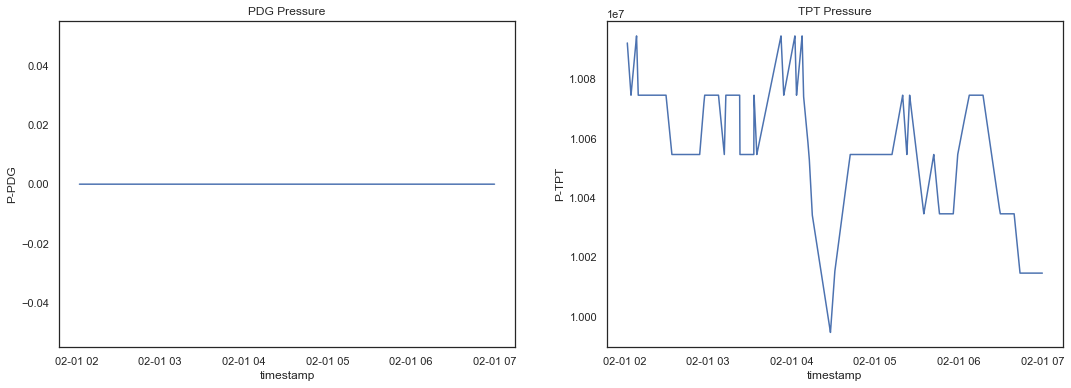

In [60]:
f, ax = plt.subplots(ncols=2, figsize=(18, 6))
sns.lineplot(data=data.resample('1S').mean()["P-PDG"], ax=ax[0])
sns.lineplot(data=data["P-TPT"], ax=ax[1])
ax[0].set_title("PDG Pressure")
ax[1].set_title("TPT Pressure")

<AxesSubplot:xlabel='timestamp', ylabel='T-JUS-CKP'>

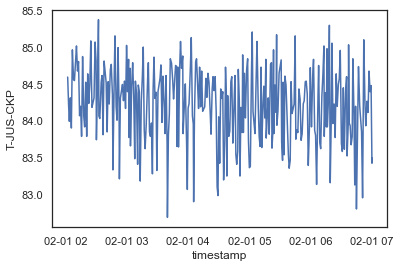

In [10]:
sns.lineplot(x="timestamp", y="T-JUS-CKP", data=data)

<AxesSubplot:xlabel='timestamp', ylabel='P-JUS-CKGL'>

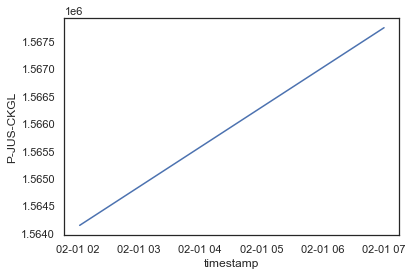

In [11]:
sns.lineplot(x="timestamp", y="P-JUS-CKGL", data=data)

In [28]:
STEPS = 10

In [29]:
def create_sequence(data, steps=STEPS):
    xs, ys = [], []
    for i in range(len(data) - steps):
        xs.append(data.iloc[i:(i+steps)].values)
        ys.append(data.iloc[i+steps].values)
        
    return np.array(xs), np.array(ys)

In [44]:
x_train, y_train = create_sequence(preprocessed_data)

In [52]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.RepeatVector(x_train.shape[1]))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(x_train.shape[2])))

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='mae')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128)               70144     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 10, 128)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 10, 128)           131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 8)             1032      
Total params: 202,760
Trainable params: 202,760
Non-trainable params: 0
________________________________________________

In [46]:
y_train = y_train.reshape(3566, 1, 8)

In [53]:
h = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
90/90 [==============================] - 7s 31ms/step - loss: 0.4532 - val_loss: 0.5520
Epoch 2/100
90/90 [==============================] - 2s 22ms/step - loss: 0.3499 - val_loss: 0.4206
Epoch 3/100
90/90 [==============================] - 2s 21ms/step - loss: 0.2809 - val_loss: 0.3473
Epoch 4/100
90/90 [==============================] - 2s 22ms/step - loss: 0.2494 - val_loss: 0.3006
Epoch 5/100
90/90 [==============================] - 2s 20ms/step - loss: 0.2349 - val_loss: 0.2825
Epoch 6/100
90/90 [==============================] - 2s 20ms/step - loss: 0.2228 - val_loss: 0.2707
Epoch 7/100
90/90 [==============================] - 2s 22ms/step - loss: 0.2135 - val_loss: 0.2619
Epoch 8/100
90/90 [==============================] - 2s 22ms/step - loss: 0.2061 - val_loss: 0.2527
Epoch 9/100
90/90 [==============================] - 2s 24ms/step - loss: 0.1990 - val_loss: 0.2463
Epoch 10/100
90/90 [==============================] - 2s 22ms/step - loss: 0.1932 - val_loss: 0.2401

Text(0, 0.5, 'MAE')

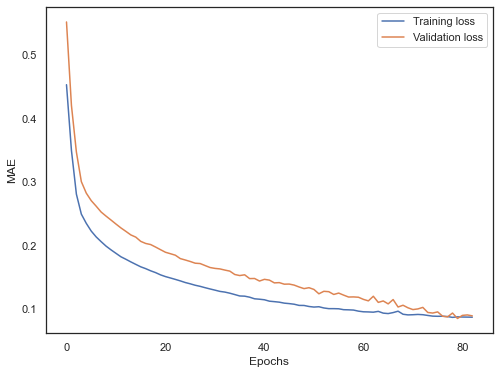

In [60]:
plt.figure(figsize=(8,6))
plt.plot(h.history['loss'], label='Training loss')
plt.plot(h.history['val_loss'], label='Validation loss')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("MAE")

In [62]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [65]:
threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 3.307956747300511


### Test

In [67]:
test_data = pd.read_csv(files[1])

test_data["timestamp"] = pd.to_datetime(test_data["timestamp"])
test_data = test_data.set_index("timestamp")

# Resample data for 5 second interval
test_data = test_data.resample('5S').mean()

test_data = test_data.drop("class", axis=1)
test_data = scaler.transform(test_data)
test_data = pd.DataFrame(data=test_data, columns=data.columns)
test_data = test_data.fillna(0)

In [81]:
x_test, y_test = create_sequence(test_data)

In [83]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

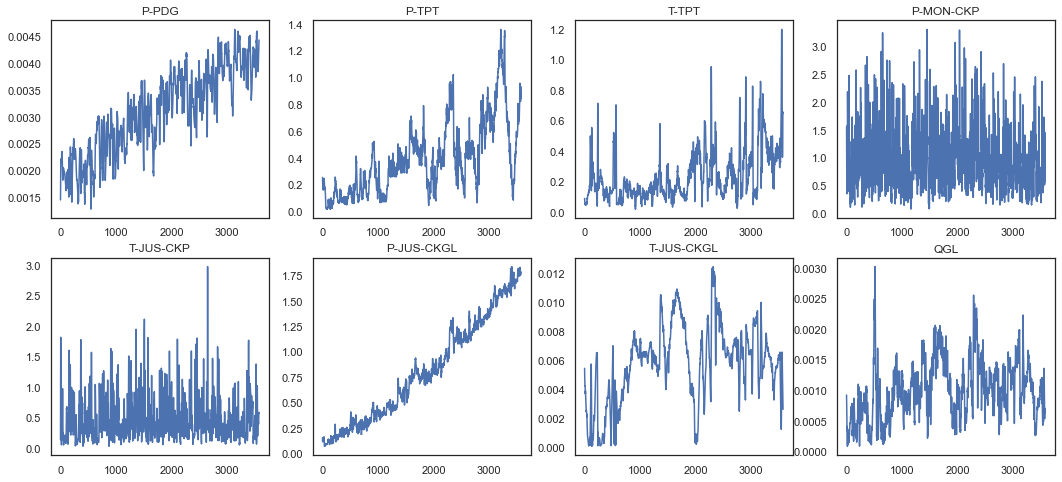

In [108]:
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
for i in range(2):
    for j in range(4):
        ax[i][j].plot(test_mae_loss[:, i*4 + j])
        ax[i][j].set_title(data.columns[i*4 + j])